In [41]:
!pip install scanpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 16.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.14.2
    Uninstalling statsmodels-0.14.2:
      Successfully uninstalled statsmodels-0.14.2


In [61]:
!pip install mygene

In [57]:
!pip install sanbomics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.9 MB/s eta 0:00:00


In [74]:
import os
import pickle as pkl
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

counts_df = pd.read_csv("airway_counts.csv", index_col=0)
metadata = pd.read_csv("airway_metadata.csv", index_col=0)

metadata["dex"] = metadata["dex"].astype("category")
metadata["dex"] = metadata["dex"].cat.reorder_categories(["untrt", "trt"], ordered=True)

counts_df = counts_df.T
samples_to_keep = ~metadata.cell.isna()
samples_to_keep = ~metadata.dex.isna()
counts_df = counts_df.loc[samples_to_keep]
metadata = metadata.loc[samples_to_keep]
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]


inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts = counts_df,
    metadata = metadata,
    design = '~ cell + dex',
    refit_cooks=True,
    inference=inference,
    
) 
dds.deseq2()

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.45 seconds.

Fitting dispersion trend curve...
... done in 0.52 seconds.

/opt/anaconda3/lib/python3.12/site-packages/pydeseq2/dds.py:542: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 4.82 seconds.

Fitting LFCs...
... done in 3.22 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



In [52]:
print(dds)

AnnData object with n_obs × n_vars = 8 × 22369
    obs: 'SampleName', 'cell', 'dex', 'albut', 'Run', 'avgLength', 'Experiment', 'Sample', 'BioSample'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'normed_counts', '_mu_hat', 'cooks'


In [75]:
stat_res = DeseqStats(
    dds=dds,
    contrast=["dex", "trt", "untrt"],  # Compare treated vs untreated
    inference=DefaultInference(n_cpus=4)
)
stat_res.run_wald_test()
results_df = stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: dex trt vs untrt
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000000003   708.597862       -0.381182  0.110852 -3.438670  0.000585   
ENSG00000000419   520.296297        0.206824  0.119605  1.729226  0.083769   
ENSG00000000457   237.162104        0.037904  0.147695  0.256640  0.797457   
ENSG00000000460    57.932380       -0.091303  0.270505 -0.337526  0.735720   
ENSG00000000971  5817.310817        0.426353  0.096253  4.429512  0.000009   
...                      ...             ...       ...       ...       ...   
ENSG00000273483     2.689552        0.818056  1.189086  0.687970  0.491472   
ENSG00000273485     1.286463       -0.128145  1.605822 -0.079800  0.936396   
ENSG00000273486    15.452443       -0.149208  0.472706 -0.315647  0.752271   
ENSG00000273487     8.163269        1.042016  0.667799  1.560374  0.118671   
ENSG00000273488     8.584371        0.110297  0.625310  0.176387  0.859990   

        

... done in 2.62 seconds.



In [76]:
print(dds.varm["dispersions"])

[0.01029337 0.01179301 0.01669506 ... 0.14698048 0.28874629 0.2492404 ]


In [28]:
print(dds.varm["LFC"])

                 Intercept  cell[T.N061011]  cell[T.N080611]  cell[T.N61311]  \
ENSG00000000003   6.375715         0.060590         0.237859       -0.151649   
ENSG00000000419   6.358188        -0.084659        -0.007040       -0.047122   
ENSG00000000457   5.465341         0.060364        -0.047995        0.049066   
ENSG00000000460   3.712390         0.543618         0.267318        0.350108   
ENSG00000000971   8.808783         0.179713         0.149995       -0.469178   
...                    ...              ...              ...             ...   
ENSG00000273483   0.400850         1.060022         0.627280        1.260325   
ENSG00000273485   0.083819        -0.757214        -0.377740        0.852139   
ENSG00000273486   2.766485        -0.306947         0.184271       -0.256475   
ENSG00000273487   2.469659        -0.179821        -0.006773       -0.162114   
ENSG00000273488   1.800166         0.829592         0.445825        0.070214   

                 dex[T.untrt]  
ENSG000

In [34]:
ds_trt_vs_untrt = DeseqStats(dds, contrast=["dex", "trt", "untrt"], inference=inference)
ds_trt_vs_untrt.summary()

Running Wald tests...
... done in 5.62 seconds.



Log2 fold change & Wald test p-value: dex trt vs untrt
                    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000000003   708.597862       -0.381182  0.110940 -3.435919  0.000591   
ENSG00000000419   520.296297        0.206823  0.119690  1.727999  0.083988   
ENSG00000000457   237.162104        0.037904  0.147769  0.256506  0.797560   
ENSG00000000460    57.932380       -0.091290  0.270568 -0.337400  0.735815   
ENSG00000000971  5817.310817        0.426352  0.096351  4.424991  0.000010   
...                      ...             ...       ...       ...       ...   
ENSG00000273483     2.689552        0.818116  1.189206  0.687951  0.491483   
ENSG00000273485     1.286463       -0.128184  1.605963 -0.079818  0.936382   
ENSG00000273486    15.452443       -0.149217  0.472771 -0.315622  0.752289   
ENSG00000273487     8.163269        1.042027  0.667874  1.560215  0.118709   
ENSG00000273488     8.584371        0.110282  0.625385  0.176342  0.860025   

        

In [38]:
res = ds_trt_vs_untrt.results_df
res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000000003,708.597862,-0.381182,0.110940,-3.435919,0.000591,0.004304
ENSG00000000419,520.296297,0.206823,0.119690,1.727999,0.083988,0.237119
ENSG00000000457,237.162104,0.037904,0.147769,0.256506,0.797560,0.914037
ENSG00000000460,57.932380,-0.091290,0.270568,-0.337400,0.735815,0.884200
ENSG00000000971,5817.310817,0.426352,0.096351,4.424991,0.000010,0.000110
...,...,...,...,...,...,...
ENSG00000273483,2.689552,0.818116,1.189206,0.687951,0.491483,NaN
ENSG00000273485,1.286463,-0.128184,1.605963,-0.079818,0.936382,NaN
ENSG00000273486,15.452443,-0.149217,0.472771,-0.315622,0.752289,0.892629
ENSG00000273487,8.163269,1.042027,0.667874,1.560215,0.118709,0.304620


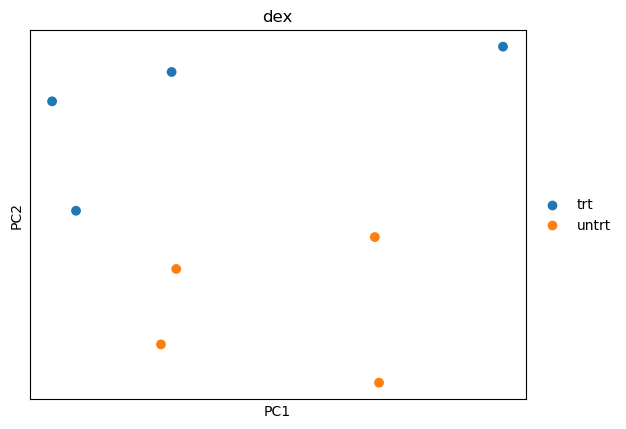

In [44]:
sc.tl.pca(dds)
sc.pl.pca(dds, color = "dex", size = 200)

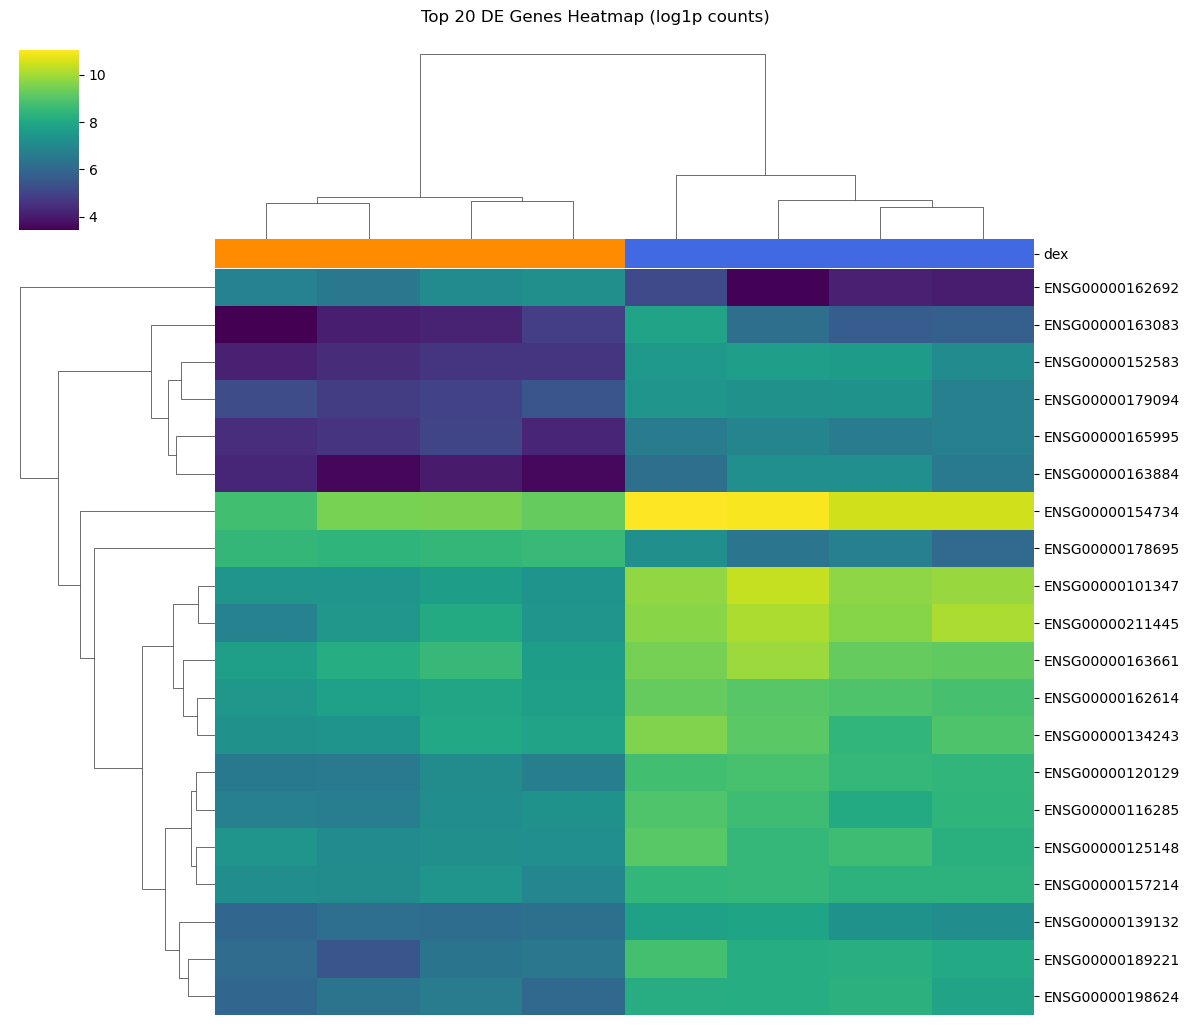

In [47]:
top_genes = res.sort_values("padj").dropna().head(20).index.tolist()
log_counts = np.log1p(counts_df[top_genes])
row_colors = metadata["dex"].map({"trt": "royalblue", "untrt": "darkorange"})

# Plot
sns.clustermap(
    log_counts.T,                  # transpose to have genes as rows
    col_colors=row_colors,
    cmap="viridis",
    figsize=(12, 10),
    xticklabels=False,
    yticklabels=True
)
plt.suptitle("Top 20 DE Genes Heatmap (log1p counts)", y=1.02)
plt.show()

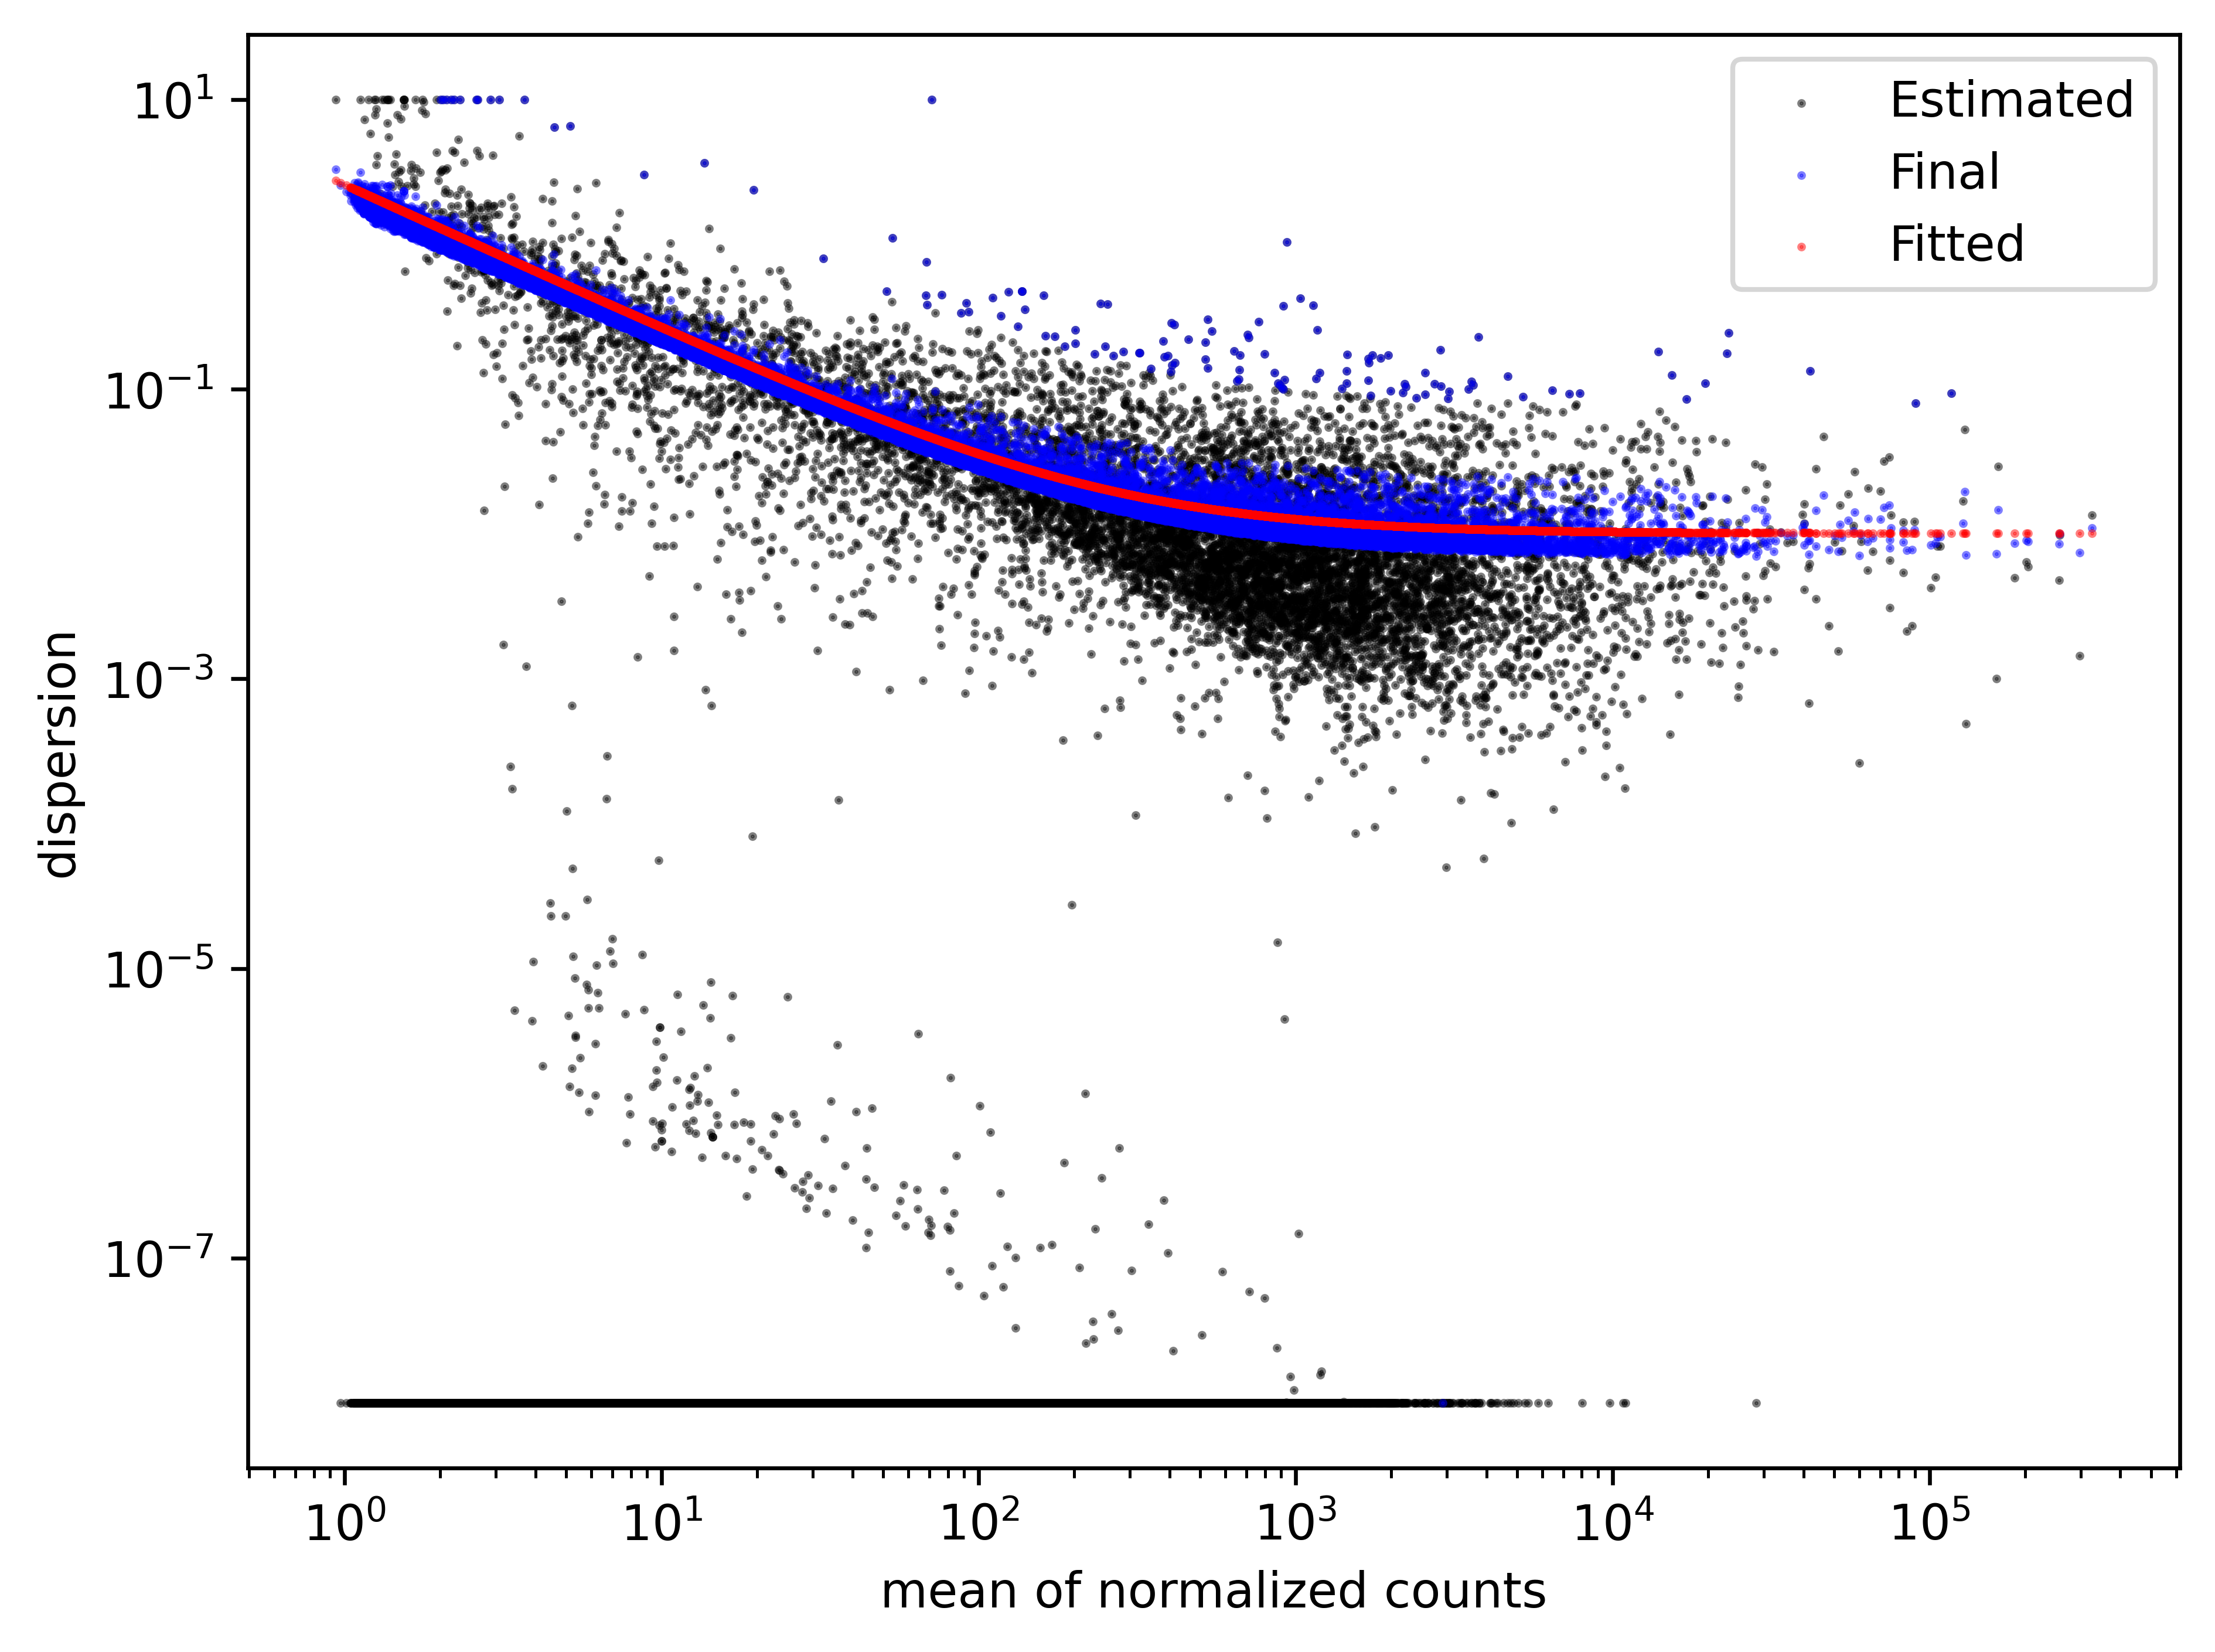

In [48]:
dds.plot_dispersions()

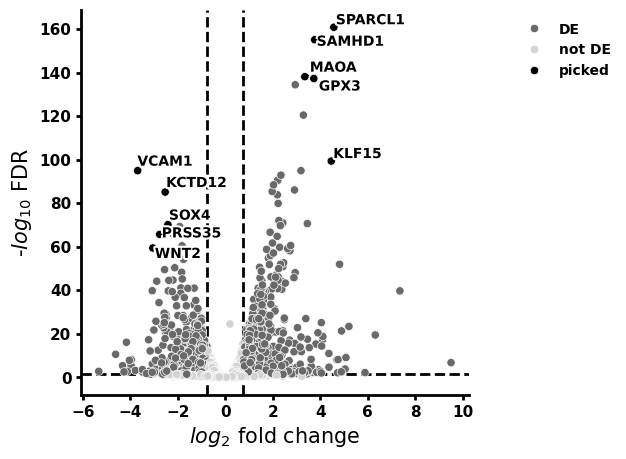

In [64]:
from sanbomics.plots import volcano
volcano(res, symbol = 'Symbol')

In [62]:
import mygene

# Create a MyGeneInfo client
mg = mygene.MyGeneInfo()

# Get gene symbols for Ensembl IDs (batch query)
ensembl_ids = res.index.tolist()
gene_info = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='human')

# Convert to DataFrame
gene_df = pd.DataFrame(gene_info)[['query', 'symbol']].dropna()
gene_df = gene_df.rename(columns={'query': 'ensembl', 'symbol': 'Symbol'})

# Merge with your DE results
res = res.reset_index().rename(columns={"index": "ensembl"})
res = res.merge(gene_df, on="ensembl", how="left")
res = res.set_index("ensembl")


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
5 input query terms found dup hits:	[('ENSG00000188660', 2), ('ENSG00000215156', 2), ('ENSG00000227110', 2), ('ENSG00000234352', 2), ('E
1247 input query terms found no hit:	['ENSG00000005955', 'ENSG00000006114', 'ENSG00000017621', 'ENSG00000031544', 'ENSG00000034063', 'ENS


In [65]:
# Drop NA padj values
filtered_res = res.dropna(subset=["padj"])

# Sort by adjusted p-value and get top 20
top20_genes = filtered_res.sort_values("padj").head(20)

# Display Ensembl ID, Gene Symbol (if available), and padj
top20_genes_info = top20_genes[["Symbol", "padj"]] if "Symbol" in top20_genes.columns else top20_genes[["padj"]]

# Show result
print(top20_genes_info)


                  Symbol           padj
ensembl                                
ENSG00000152583  SPARCL1  1.392105e-161
ENSG00000101347   SAMHD1  7.765806e-156
ENSG00000189221     MAOA  7.379528e-139
ENSG00000211445     GPX3  5.229251e-138
ENSG00000120129    DUSP1  3.833576e-135
ENSG00000165995   CACNB2  3.372633e-121
ENSG00000163884    KLF15  4.508281e-100
ENSG00000179094     PER1   1.174829e-95
ENSG00000162692    VCAM1   1.174829e-95
ENSG00000154734  ADAMTS1   1.361183e-93
ENSG00000125148     MT2A   3.136461e-91
ENSG00000162614     NEXN   3.831485e-89
ENSG00000198624   CCDC69   8.694908e-87
ENSG00000157214   STEAP2   4.288630e-86
ENSG00000178695   KCTD12   7.857579e-86
ENSG00000134243    SORT1   1.443974e-84
ENSG00000139132     FGD4   1.303816e-80
ENSG00000163661     PTX3   9.637460e-73
ENSG00000116285   ERRFI1   1.104145e-71
ENSG00000163083    INHBB   2.410575e-71


In [63]:
res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol
ensembl,,,,,,,
ENSG00000000003,708.597862,-0.381182,0.110940,-3.435919,0.000591,0.004304,TSPAN6
ENSG00000000419,520.296297,0.206823,0.119690,1.727999,0.083988,0.237119,DPM1
ENSG00000000457,237.162104,0.037904,0.147769,0.256506,0.797560,0.914037,SCYL3
ENSG00000000460,57.932380,-0.091290,0.270568,-0.337400,0.735815,0.884200,FIRRM
ENSG00000000971,5817.310817,0.426352,0.096351,4.424991,0.000010,0.000110,CFH
...,...,...,...,...,...,...,...
ENSG00000273483,2.689552,0.818116,1.189206,0.687951,0.491483,NaN,NaN
ENSG00000273485,1.286463,-0.128184,1.605963,-0.079818,0.936382,NaN,NaN
ENSG00000273486,15.452443,-0.149217,0.472771,-0.315622,0.752289,0.892629,NaN


In [11]:
counts_df

,SRR1039508,SRR1039509,SRR1039512,SRR1039513,SRR1039516,SRR1039517,SRR1039520,SRR1039521
ENSG00000000003,679,448,873,408,1138,1047,770,572
ENSG00000000005,0,0,0,0,0,0,0,0
ENSG00000000419,467,515,621,365,587,799,417,508
ENSG00000000457,260,211,263,164,245,331,233,229
ENSG00000000460,60,55,40,35,78,63,76,60
...,...,...,...,...,...,...,...,...
ENSG00000273489,0,0,0,1,0,1,0,0
ENSG00000273490,0,0,0,0,0,0,0,0
ENSG00000273491,0,0,0,0,0,0,0,0
ENSG00000273492,0,0,1,0,0,0,0,0


In [12]:
metadata

,SampleName,cell,dex,albut,Run,avgLength,Experiment,Sample,BioSample
SRR1039508,GSM1275862,N61311,untrt,untrt,SRR1039508,126,SRX384345,SRS508568,SAMN02422669
SRR1039509,GSM1275863,N61311,trt,untrt,SRR1039509,126,SRX384346,SRS508567,SAMN02422675
SRR1039512,GSM1275866,N052611,untrt,untrt,SRR1039512,126,SRX384349,SRS508571,SAMN02422678
SRR1039513,GSM1275867,N052611,trt,untrt,SRR1039513,87,SRX384350,SRS508572,SAMN02422670
SRR1039516,GSM1275870,N080611,untrt,untrt,SRR1039516,120,SRX384353,SRS508575,SAMN02422682
SRR1039517,GSM1275871,N080611,trt,untrt,SRR1039517,126,SRX384354,SRS508576,SAMN02422673
SRR1039520,GSM1275874,N061011,untrt,untrt,SRR1039520,101,SRX384357,SRS508579,SAMN02422683
SRR1039521,GSM1275875,N061011,trt,untrt,SRR1039521,98,SRX384358,SRS508580,SAMN02422677
